Parameters used in the code:

N: Number of sites in the transverse field Ising model.

This code can optimize 12 or higher sites because we are using JAX with GPU support

B: B-field value for the target Hamiltonian, which can be zero or non-zero.

J_value: J coupling strength.

J_matrix_alpha: Power-law decay constant.

number_of_layers: The number of steps in the optimization.

There are two final output files,
 - 'jax_bfgs_lambda_B_log_N={N}_layers_{number_of_layers}.txt' , this records the update during each iteration
 - 'jax_bfgs_latest_state_N={N}_layers_{number_of_layers}.txt', this records the final state

In [1]:
# initialize variables
N = 12
B = 0.1
J_value = 1
J_matrix_alpha =  1
number_of_layers = 10

This code was executed on Google Colab. To run it on a local machine, one will need to update the directory paths accordingly.

The relevant paths are as follows:

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the root directory of your Google Drive
drive_root = '/content/drive/My Drive/MTE_and_QAOA'


log_file_path = f'{drive_root}/jax_bfgs_lambda_B_log_N={N}_layers_{number_of_layers}.txt'
latest_state_file_path = f'{drive_root}/jax_bfgs_latest_state_N={N}_layers_{number_of_layers}.txt'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install packages on the cloud
!pip install optax
!pip install jaxopt

In [4]:
import jax.numpy as jnp
from jax import grad, jit
import jax.numpy.linalg as jla
import jax.scipy.optimize as jso
import jax
jax.config.update("jax_enable_x64", True)
import numpy as np
from scipy.sparse.linalg import eigs
from numpy import linalg as LA
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy
np.set_printoptions(precision=6)
# Q is the dimension
Q = pow(2, N)

# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array

# start my main function

# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')
for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

In [5]:
jax.devices()

[cuda(id=0)]

In [6]:
# start to get what product states are having the same symmtries
loop_state_list = np.linspace(0,Q-1,num=Q,dtype=int)

couple_state_matrix = []
sign_matrix = []
# this is the final result for the states to consctruct basis

for n in range(Q):  # n is an unused index

    # couple_num_list would be my result for each state we loop

    if len(loop_state_list)!=0: # loop for couple number for one state

        couple_num_list = [] # this is the list to store all the number that couple to the number we are looping
        couple_num_list = np.array(couple_num_list, dtype=int)
        state_num = loop_state_list[0]
        couple_num_list = np.append(couple_num_list,state_num)

        for m in range(Q): # loop for spin and spatial for all states inside the couple number list

            if m==0:

                couple_num_list_old =couple_num_list

                for i in range(len(couple_num_list)):
                    number = couple_num_list[i]
                    array = D2B(number)

                    # spin reflection
                    spin_relfection_array = spin_reflection(array)
                    spin_number = B2D(spin_relfection_array)
                    couple_num_list =np.append(couple_num_list,spin_number)



                    # spatial reflection
                    spatial_relfection_array = spatial_reflection(array)
                    spatial_number = B2D(spatial_relfection_array)
                    couple_num_list =np.append(couple_num_list,spatial_number)

                    # remove the repeated element
                    couple_num_list = np.unique(couple_num_list)
            else:

                if len(couple_num_list_old) != len(couple_num_list):
                    # update couple_num_list_old first
                    couple_num_list_old =couple_num_list

                    for i in range(len(couple_num_list)):
                        number = couple_num_list[i]
                        array = D2B(number)

                        # spin reflection
                        spin_relfection_array = spin_reflection(array)
                        spin_number = B2D(spin_relfection_array)
                        couple_num_list =np.append(couple_num_list,spin_number)


                        # spatial reflection
                        spatial_relfection_array = spatial_reflection(array)
                        spatial_number = B2D(spatial_relfection_array)
                        couple_num_list = np.append(couple_num_list,spatial_number)

                        # remove the repeated element
                        couple_num_list = np.unique(couple_num_list)

        # now we have final couple_num_list
        couple_state_matrix.append(couple_num_list.tolist())

        # remove the ones already found
        for j in range(len(couple_num_list)):
            loop_state_list = np.delete(loop_state_list, np.where(loop_state_list ==couple_num_list[j] ))

In [7]:
# initialize H matrix
couple_dimen = len(couple_state_matrix)
HA_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')
HB_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')

In [8]:
print('Hamiltonian dimension is ', couple_dimen)

Hamiltonian dimension is  1056


In [9]:
# loop each basis to fill in the diagonal elements for HA matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # loop each element inside the array
    normalization = len(state_array)

    # energy total for all the product states inside one basis

    e_tot = 0
    for j in range(len(state_array)):

        state = D2B(state_array[j])

        # loop over N sites to change the state vector to either 1 or -1

        for k in range(N):
            # 1 is spin down , 0 is spin up
            if state[k] == 1:
                state[k] = -1
            else:
                state[k] = 1

        # now get the energy, loop all the sites and then pairs

        for m in range(N):
            for q in range(N):
                e_temp = J_matrix[m][q] * state[m] * state[q]
                e_tot = e_tot + e_temp

    HA_matrix[i][i] = e_tot/normalization

In [10]:
# generate vector form for each basis
vector_form_basis_matrix = np.zeros((couple_dimen,Q))

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )
    normalization = np.sqrt(len(state_array))

    for j in state_array:
        vector_form_basis_matrix[i][j] = 1

    # put back normalization factor
    vector_form_basis_matrix[i] = vector_form_basis_matrix[i]/normalization

In [11]:
# loop each basis to fill in HB matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # this is the actual normalization unlike before since it will couple to some other states
    # so it can not be like just the square like we did before
    normalization = np.sqrt(len(state_array))

    # loop each product state to generate N other states, i.e. generaete the state after operator acting on it
    result_num_list = []
    result_num_list = np.array(result_num_list,dtype=int)
    for k in range(len(state_array)):

        spin = D2B(state_array[k])

        # start fliping the spins
        for j in range(N):
            if spin[j] == 1:
                # if it's spin down, raise to spin up
                spin[j] = 0
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 1
            else:
                # if it's spin down, raise to spin up
                spin[j] = 1
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 0


    # generate the vector form for the state after operrator acting on it

    vector_final_state = np.zeros(Q)

    for j in result_num_list:
        vector_final_state[j] = vector_final_state[j] +1

    # put back normalization factor
    vector_final_state = vector_final_state/normalization

    # calculate dot product to put into inside the matrix
    for j in range(couple_dimen):

        dot_product = np.dot(vector_final_state,vector_form_basis_matrix[j])
        HB_matrix[i][j] = dot_product

In [12]:
# After constructing couple_state_matrix
HA_matrix = jnp.array(HA_matrix,dtype=jnp.float64)
HB_matrix = jnp.array(HB_matrix,dtype=jnp.float64)

In [13]:
# Compute eigenvalues and eigenvectors using JAX
w, v = jla.eigh(HA_matrix + B * HB_matrix)

# Extract the true ground state vector and energy
true_gs_vec = v[:,0]
true_gs_energy = w[0]
E_max = w[-1]

In [14]:
print('true ground state energy is', true_gs_energy)

true ground state energy is -7.8879431695379765


In [15]:
# get  ground state with just H_B
w, v = jla.eigh(HB_matrix)
temp_vec = v[:,0] # the index here could be zero or one, depending on the parity
# but if the wrong index will always give roughly zero fidelity

In [16]:
def get_energy(H_matrix, state):
    a = jnp.dot(H_matrix, state)
    energy = jnp.dot(jnp.conj(state), a).real
    return energy

In [17]:
def get_fidelity(gs, state):
    dp = jnp.dot(gs, state)  # Dot product
    dp_cc = jnp.conj(dp)     # Complex conjugate of the dot product
    return (dp * dp_cc).real

In [18]:
fidelity_t_0 = get_fidelity(true_gs_vec, temp_vec)
print('fidelity before optim is', fidelity_t_0)

fidelity before optim is 0.0013894250289274643


In [19]:
target_H = jnp.copy(HA_matrix + B * HB_matrix)

In [20]:
# confirm it is the same as true_gs_energy
get_energy(target_H,true_gs_vec).item()

-7.887943169537969

In [21]:
from jax.scipy.linalg import expm
def lambda_evolve(x):
    p = temp_vec  # p stands for product
    for i in range(number_of_layers):
        H_matrix = HA_matrix + x[i + number_of_layers] * HB_matrix
        exp_imgH_matrix = expm(-1j * x[i] * H_matrix)
        new_p = jnp.dot(exp_imgH_matrix, p)
        p = new_p

    energy = get_energy(target_H, p)
    return energy

In [22]:
def lambda_evolve_fidelity(x):
    p = temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + x[i + number_of_layers] * HB_matrix
        exp_imgH_matrix = expm(-1j * x[i] * H_matrix)
        new_p = jnp.dot(exp_imgH_matrix, p)
        p = new_p

    fidelity = get_fidelity(true_gs_vec, p)
    norm_p = jnp.linalg.norm(p)
    return fidelity, norm_p


In [23]:
def exp_decay_guess_new(B_0, B_f, j):
    tau = np.log(B_0 / B_f)
    value = B_0 * np.exp(-j * tau / (number_of_layers - 1))  # Adjust for exact B_0 and B_f
    return value

# Parameters
B_0 = 1                 # Initial value (starts here)
B_f = 0.1               # Final value (ends here)
# Generate B_guess using the new method
layer_indices = np.arange(0, number_of_layers)  # Adjust indices to go from 0 to number_of_layers - 1
B_guess = np.array([exp_decay_guess_new(B_0, B_f, j) for j in layer_indices])

# Generate random lambada_guess using NumPy
lambada_guess = np.random.uniform(1, 2, number_of_layers)
x = np.concatenate((lambada_guess, B_guess))

x = jnp.array(x,dtype=jnp.float64)

In [24]:
from jax.scipy.optimize import minimize as jax_minimize

# Perform optimization using jax.scipy.optimize.minimize with JIT compilation
@jax.jit
def jit_lambda_evolve(x):
    return lambda_evolve(x)

In [25]:
# Function to convert parameters to string with full precision and commas as separators
def params_to_string(params):
    return ', '.join(f'{p:.16f}' for p in params)

In [26]:
# # ADAM method
# import jax
# import jax.numpy as jnp
# from jax import jit, grad
# import optax

# # Define the number of iterations
# iterations = 10000

# # Initial parameters
# params = x

# # Define the learning rate
# learning_rate = 0.001

# # Initialize the ADAM optimizer
# optimizer = optax.adam(learning_rate)
# opt_state = optimizer.init(params)

# # Define a function to update parameters
# @jit
# def update(params, opt_state):
#     grads = grad(jit_lambda_evolve)(params)
#     updates, opt_state = optimizer.update(grads, opt_state)
#     new_params = optax.apply_updates(params, updates)
#     return new_params, opt_state

# # List to store the cost values
# cost_values = []

# # Run the optimization loop
# for i in range(iterations):
#     params, opt_state = update(params, opt_state)
#     cost = jit_lambda_evolve(params)
#     cost_values.append(cost)
#     if i % 1 == 0:
#         print(f"Iteration {i}, Cost: {cost}")

# # The optimized parameters
# optimized_params = params

# # Print the final cost value
# print(f"Final cost: {cost_values[-1]}")



In [29]:
from jaxopt import BFGS

iterations = 10000

# Initial parameters
params = x  # param to update

# # Create an instance of BFGS optimizer
opt = BFGS(fun=lambda_evolve)

# Initialize the optimizer state
state = opt.init_state(params)

# List to store the cost values
cost_values = []

with open(log_file_path, 'a') as f:
    # Optimization loop
    for i in range(iterations):
        # Perform one iteration of BFGS
        params, state = opt.update(params, state)

        # Append the current cost to the list
        cost_values.append(state.value)

        # Print the current cost and parameters
        print(f"Iteration {i}: params = {params}, cost = {state.value}")

        # Write the cost value and parameters to the file during each step
        f.write(f"Iteration {i}: cost = {state.value}, params = {params_to_string(params)}\n")


        # Write the latest state to another file, overwriting previous content
        with open(latest_state_file_path, 'w') as state_file:
            state_file.write(f"Iteration {i}: state = {state}\n")

        # check if converge
        grad_norm = jax.numpy.linalg.norm(state.grad)
        if grad_norm < 1e-5:
            break


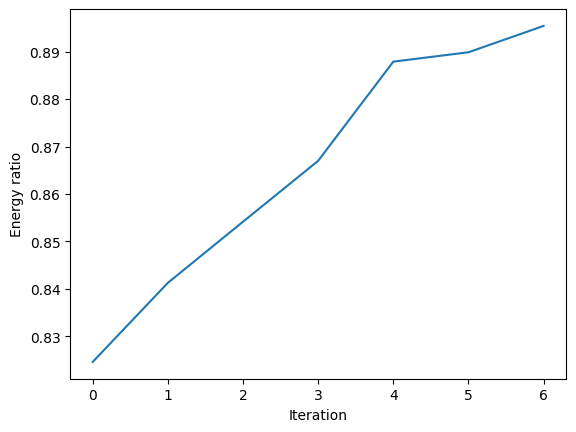

In [43]:
cost_values = np.array(cost_values)
# Plot the cost values
plt.plot((cost_values/true_gs_energy))
plt.xlabel('Iteration')
plt.ylabel('Energy ratio')
plt.xlim()
plt.show()

In [27]:
########################################################################################################
#best result N=12,10 LAYERS

x_10 =np.array([0.4072185919308115, 1.2954691806813516, 0.5805573609066998, 0.8454189546075643, 1.2243197218332320, 2.1572222947038711, 2.5905765854250022, 2.7409062412055198, 2.0081536293189819, 0.9755810490605400, 4.9955913368774452, 1.7717120168593767, 1.0871728400196139, 0.7185240323450447, 0.5732536483420920, 0.4951459317676031, 0.4388398363271400, 0.3901464618527199, 0.3117549554184353, 0.1945036761838408])

########################################################################################################
# best result N=12,19 LAYERS
x_20 =np.array([ 0.327776,  0.474971,  0.273948,  1.144375,  0.39613 ,  0.469455,
        0.61746 ,  0.71229 ,  1.606741,  2.45683 ,  2.329665,  2.300839,
        2.067805,  0.767213,  1.982016,  1.088733,  1.654539,  1.20256 ,
        1.599378, 11.170304,  4.166785,  2.284776,  1.569997,  1.193193,
        0.900791,  0.749189,  0.627265,  0.558349,  0.48868 ,  0.448456,
        0.420571,  0.379537,  0.343144,  0.301675,  0.264275,  0.237982,
        0.170687,  0.123693])

########################################################################################################
# best result N=12,28 LAYERS
x_30 =np.array([ 0.372775,  0.179961,  0.390973,  1.425035,  0.510744,  1.729341,
        0.450043,  0.453797,  1.903975,  1.265933,  0.588657,  1.078548,
        0.579753,  1.712308,  0.678603,  1.718906,  2.534426,  1.285703,
        1.341049,  0.693764,  0.570384,  0.675155,  0.808742,  2.114068,
        0.826767,  0.870555,  1.020514,  1.043119, 13.586468,  3.363042,
        1.634305,  1.4103  ,  1.21528 ,  1.117821,  0.991998,  0.83695 ,
        0.743113,  0.717898,  0.658147,  0.626936,  0.603037,  0.547218,
        0.514397,  0.480427,  0.454724,  0.420769,  0.430994,  0.392782,
        0.36764 ,  0.342992,  0.306503,  0.275602,  0.250099,  0.211784,
        0.173192,  0.123975])

########################################################################################################


# best result N=12,46 LAYERS
x_50 =np.array([ 0.097725,  0.477288,  0.443276,  0.172682,  1.246086,  0.880701,
        0.311077,  0.343559,  0.4446  ,  0.498634,  3.513766,  2.195835,
       -1.679474,  2.34228 ,  1.033489,  3.00999 , -0.583254, -1.904584,
        6.23439 ,  0.627215,  0.72342 ,  0.945287,  0.84764 ,  2.777252,
        0.920419,  0.795509,  0.771761,  1.074029,  0.849288,  0.778886,
        2.109009,  2.799745,  2.618029,  9.436081, -6.322151,  9.304835,
        0.817901,  0.557422,  0.670992,  0.875811,  5.658462, -0.068928,
        0.289072,  5.464772,  2.425481,  1.070671, 23.078089,  7.676801,
        4.609007,  3.1356  ,  2.488154,  2.080197,  1.473614,  1.071259,
        0.827909,  0.710397,  0.655159,  0.635309,  0.610464,  0.589641,
        0.570621,  0.552939,  0.528794,  0.507812,  0.486003,  0.456375,
        0.418009,  0.388989,  0.374755,  0.359278,  0.349239,  0.336304,
        0.314521,  0.293763,  0.279373,  0.261307,  0.24796 ,  0.243052,
        0.236972,  0.232609,  0.236054,  0.227522,  0.218561,  0.199195,
        0.179152,  0.151823,  0.135518,  0.330649,  0.170398,  0.117737,
        0.115771,  0.107222])


########################################################################################################
# NOTE: The number of steps was supposed to be 10,20,30 and 50. But after the optimization, values fall below 10^-2 are removed, thus resulting number of steps in 10, 19, 28 and 46.

In [38]:
# Example usage based on previously optimized data
number_of_layers = len(x_50)//2
print('energy ratio is', lambda_evolve(x_50)/true_gs_energy)

energy ratio is 0.9998506800308802
